## Visualization of Gaussian Kernel

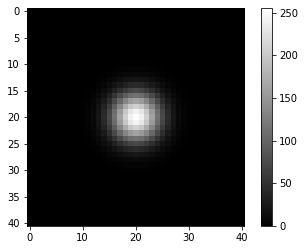

In [1]:
import glob
import csv
import numpy
import matplotlib.pyplot as plt
from PIL import Image
import os 

size = 20 
def gaussian_kernel(variance):
    x, y = numpy.mgrid[-size:size+1, -size:size+1]
    g = numpy.exp(-(x**2+y**2)/float(2*variance))
    return g 


variance = 10
gaussian_kernel_array = gaussian_kernel(variance)
temporary = len(gaussian_kernel_array)//2
gaussian_kernel_array =  gaussian_kernel_array * 255/gaussian_kernel_array[temporary][temporary]
gaussian_kernel_array = gaussian_kernel_array.astype(int)

plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('gray'), interpolation='nearest')
plt.colorbar()
plt.show()

## Generate Ground Truth

In [ ]:
for index in range(1,95):
        pics = glob.glob("C:/Users/User/Project/Dataset1/Clip" + str(index) + "/*.jpg")
        output_pics_path = "C:/Users/User/Project/GroundTruth1/Clip" + str(index) 
        label_path = "C:/Users/User/CIP/TrackNetMirror/Dataset1/Clip" + str(index) + "/Label.csv"
        
        if not os.path.exists(output_pics_path ):
            os.makedirs(output_pics_path)

        with open(label_path, 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            next(spamreader, None)  
            
            for row in spamreader:
                    visibility = int(float(row[1]))
                    FileName = row[0]
                    if visibility == 0:
                        heatmap = Image.new("RGB", (1280, 720))
                        pix = heatmap.load()
                        for i in range(1280):
                            for j in range(720):
                                    pix[i,j] = (0,0,0)
                    else:
                        x = int(float(row[2]))
                        y = int(float(row[3]))
                        
                        heatmap = Image.new("RGB", (1280, 720))
                        pix = heatmap.load()
                        for i in range(1280):
                            for j in range(720):
                                    pix[i,j] = (0,0,0)
                                    
                        for i in range(-size,size+1):
                            for j in range(-size,size+1):
                                    if x+i<1280 and x+i>=0 and y+j<720 and y+j>=0 :
                                        temp = gaussian_kernel_array[i+size][j+size]
                                        if temp > 0:
                                            pix[x+i,y+j] = (temp,temp,temp)

                    heatmap.save(output_pics_path + "/" + FileName.split('.')[-2] + ".png", "PNG")

## Generate Input CSV file

In [ ]:
import numpy as np
import cv2
import glob
import itertools
import random
import csv

training_file_name = "train_model_3.csv"
testing_file_name = "test_model_3.csv"
visibility_for_testing = []

with open(training_file_name,'w') as file:
    for index in range(1,95):
        images_path = "C:/Users/User/Project/Dataset1/Clip" + str(index) + "/"
        ground_path = "C:/Users/User/Project/GroundTruth1/Clip" + str(index) + "/"
        
        images = glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg")
        images.sort()
        
        groundtruth = glob.glob(ground_path + "*.jpg") + glob.glob(ground_path + "*.png") +  glob.glob(ground_path + "*.jpeg")
        groundtruth.sort()
        
        assert len( images ) == len(groundtruth)
        for im , seg in zip(images,groundtruth):
            assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )

        visibility = {}
        with open(images_path + "Label.csv", 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            next(spamreader, None)  
            for row in spamreader:
                visibility[row[0]] = row[1]
                    
        for i in range(2,len(images)): 
                file_name = images[i].split('\\')[-1]
                if visibility[file_name] == '3': 
                    visibility_for_testing.append(images[i])
                assert(  images[i].split('/')[-1].split(".")[0] ==  groundtruth[i].split('/')[-1].split(".")[0] )
                file.write(images[i] + "," + images[i-1] + "," + images[i-2] + "," + groundtruth[i] + "\n")
                
                    
file.close()


lines = open(training_file_name).read().splitlines()

training_images_number = int(len(lines)*0.7)
testing_images_number = len(lines) - training_images_number
print("Total images:" + str(len(lines)) + "Training images:" + str(training_images_number) + "Testing images:" + str(testing_images_number))

random.shuffle(lines)

with open(training_file_name,'w') as training_file:
    training_file.write("img, img1, img2, ann\n")

    with open(testing_file_name,'w') as testing_file:
        testing_file.write("img, img1, img2, ann\n")
        
        for i in range(0,len(lines)):
            if lines[i] != "":
                if training_images_number > 0 and lines[i].split(",")[0] not in visibility_for_testing :
                    training_file.write(lines[i] + "\n")
                    training_images_number -=1
                else:
                    testing_file.write(lines[i] + "\n")
                    
training_file.close()
testing_file.close()
    